In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
df = pd.read_csv('dataset/cars.csv')

# Selecting multiple features  
df = df[['manufacture_year', 'engine_cc', 'horsepower', 'mileage_km_per_l', 'price_usd']].dropna()

X = df[['manufacture_year', 'engine_cc', 'horsepower', 'mileage_km_per_l']]
y = df['price_usd']

print(f"Dataset size: {len(y)} samples")
print(f"Features: {list(X.columns)}")
print(f"Number of features: {len(X.columns)}")

Dataset size: 300 samples
Features: ['manufacture_year', 'engine_cc', 'horsepower', 'mileage_km_per_l']
Number of features: 4


In [39]:
# Feature scaling
X_max = X.max()
y_max = y.max()

X = X / X_max
X = X.values

y = y / y_max
y = y.values.reshape(-1, 1)

In [40]:
# Adding 1's column for intercept
n_rows = len(y)
X = np.c_[np.ones(n_rows), X]
print(X[:5])

# Initialize theta - now we have 5 parameters (intercept + 4 features)
theta = np.zeros((5, 1))

[[1.         0.99061728 0.81878254 0.91318865 0.56666667]
 [1.         0.99901235 0.92470965 0.278798   0.83333333]
 [1.         0.99111111 0.360833   0.1836394  0.53333333]
 [1.         0.99407407 0.36744093 0.62270451 0.53333333]
 [1.         0.99209877 0.46696035 0.24207012 0.93333333]]


In [41]:
# Gradient descent
epochs = 10000
learning_rate = 0.01
m = n_rows
costs = []

for i in range(epochs):
    h = X @ theta
    error = h - y
    cost = (1/(2*m)) * np.sum(np.square(error))
    costs.append(cost)
    
    gradient = (1/m) * (X.T @ error)
    theta = theta - learning_rate * gradient

print(f"Final theta: {theta.flatten()}")

Final theta: [ 0.2316849   0.23034088  0.00869618  0.1190895  -0.03468723]


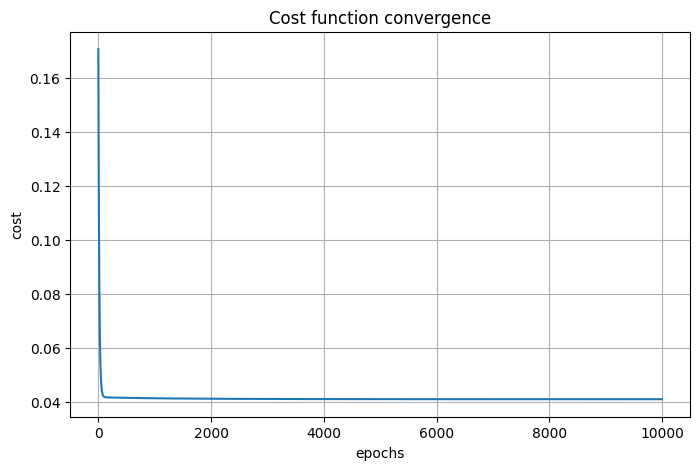

In [42]:
# Cost convergence plot
plt.figure(figsize=(8,5))
plt.plot(range(epochs), costs)
plt.title('Cost function convergence')
plt.xlabel('epochs')
plt.ylabel('cost')
plt.grid(True)
plt.show()

In [43]:
# Interpret coefficients (converting back to original scale)
intercept_original = y_max * theta[0].item()
coef_year = (y_max * theta[1].item()) / X_max['manufacture_year']
coef_engine = (y_max * theta[2].item()) / X_max['engine_cc']
coef_hp = (y_max * theta[3].item()) / X_max['horsepower']
coef_mileage = (y_max * theta[4].item()) / X_max['mileage_km_per_l']

print("\nMODEL EQUATION:")
print(f"price = {intercept_original:.2f}")
print(f"      + {coef_year:.4f} * manufacture_year")
print(f"      + {coef_engine:.4f} * engine_cc")
print(f"      + {coef_hp:.4f} * horsepower")
print(f"      + {coef_mileage:.4f} * mileage_km_per_l")

print(f"\nCOEFFICIENTS:")
print(f"Intercept: ${intercept_original:,.2f}")
print(f"Manufacture Year coefficient: ${coef_year:.4f} per year")
print(f"Engine CC coefficient: ${coef_engine:.4f} per cc")
print(f"Horsepower coefficient: ${coef_hp:.4f} per hp")
print(f"Mileage coefficient: ${coef_mileage:.4f} per km/l")


MODEL EQUATION:
price = 27706.50
      + 13.6029 * manufacture_year
      + 0.2082 * engine_cc
      + 23.7756 * horsepower
      + -138.2714 * mileage_km_per_l

COEFFICIENTS:
Intercept: $27,706.50
Manufacture Year coefficient: $13.6029 per year
Engine CC coefficient: $0.2082 per cc
Horsepower coefficient: $23.7756 per hp
Mileage coefficient: $-138.2714 per km/l


In [44]:
# Evaluation: MSE, RMSE, R²
y_pred = (X @ theta) * y_max
y_actual = y * y_max

# MSE = (1/m) * Σ(y_actual - y_pred)²
mse = (1/m) * np.sum(np.square(y_actual - y_pred))

# RMSE = √MSE
rmse = np.sqrt(mse)

# R² = 1 - (SS_res / SS_tot)
y_mean = np.mean(y_actual)
ss_res = np.sum(np.square(y_actual - y_pred))
ss_tot = np.sum(np.square(y_actual - y_mean))
r_squared = 1 - (ss_res / ss_tot)

print("\nEVALUATION METRICS:")
print(f"MSE: {mse:,.2f}")
print(f"RMSE: ${rmse:,.2f}")
print(f"R²: {r_squared:.6f} ({r_squared*100:.2f}%)")


EVALUATION METRICS:
MSE: 1,168,538,522.70
RMSE: $34,183.89
R²: 0.011840 (1.18%)


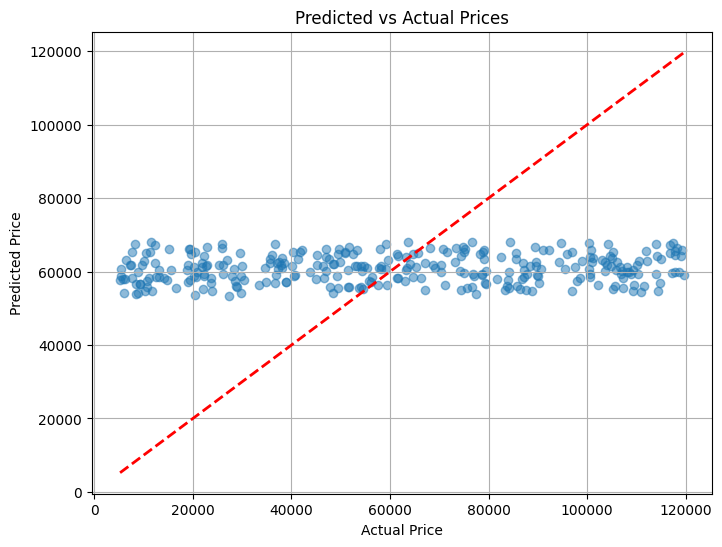

In [45]:
# Visualization: Predicted vs Actual
plt.figure(figsize=(8,6))
plt.scatter(y_actual, y_pred, alpha=0.5)
plt.plot([y_actual.min(), y_actual.max()], 
         [y_actual.min(), y_actual.max()], 
         'r--', linewidth=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Actual Prices')
plt.grid(True)
plt.show()